In [17]:
# Core
import os
import sys
import json
import math
import warnings
from pathlib import Path
from typing import List, Dict

# Data
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Reproducibility & display
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")


In [2]:

DATA_PATH = Path("C:/Users/ERDAL/Desktop/Calisma/data/CC GENERAL.csv")

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))
df.describe(include="all").T


Shape: (8950, 18)

Columns:
 ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

Missing values per column:
 MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
CUST_ID                               0
BALANCE                               0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
CASH_ADVANCE_FREQUENCY                0
PURCHASES_INSTALLMENTS_FREQUENCY      0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_FREQUENCY                   0
CASH_ADVANCE                          0
INSTALLMENTS_PURCHASES                0
ONEOFF_PURCHASES                 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CUST_ID,8950,8950,C10001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BALANCE,8950.0,NaN,NaN,NaN,1564.474828,2081.531879,0.0,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,NaN,NaN,NaN,0.877271,0.236904,0.0,0.888889,1.0,1.0,1.0
PURCHASES,8950.0,NaN,NaN,NaN,1003.204834,2136.634782,0.0,39.635,361.28,1110.13,49039.57
ONEOFF_PURCHASES,8950.0,NaN,NaN,NaN,592.437371,1659.887917,0.0,0.0,38.0,577.405,40761.25
INSTALLMENTS_PURCHASES,8950.0,NaN,NaN,NaN,411.067645,904.338115,0.0,0.0,89.0,468.6375,22500.0
CASH_ADVANCE,8950.0,NaN,NaN,NaN,978.871112,2097.163877,0.0,0.0,0.0,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.490351,0.401371,0.0,0.083333,0.5,0.916667,1.0
ONEOFF_PURCHASES_FREQUENCY,8950.0,NaN,NaN,NaN,0.202458,0.298336,0.0,0.0,0.083333,0.3,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,NaN,NaN,NaN,0.364437,0.397448,0.0,0.0,0.166667,0.75,1.0


In [4]:
# Drop exact duplicates if any
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

# CUST_ID is an identifier; keep for reference but do not use as a feature
id_col = "CUST_ID"
if id_col not in df.columns:
    raise ValueError("Expected CUST_ID column is missing.")

# Track numeric feature candidates
numeric_cols = [c for c in df.columns if c != id_col and pd.api.types.is_numeric_dtype(df[c])]
print("Numeric columns:", numeric_cols)


Removed duplicates: 0
Numeric columns: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [5]:
# Assumption: "debt" = current outstanding BALANCE.
# Good payer if they pay at least 70% of current balance: PAYMENTS / BALANCE >= 0.70
# Handle zero/near-zero balances safely.

df["BALANCE_safe"] = df["BALANCE"].replace(0, np.nan)
payment_ratio = df["PAYMENTS"] / df["BALANCE_safe"]
df["payment_ratio_to_balance"] = payment_ratio.replace([np.inf, -np.inf], np.nan)

# Create target: 1 = Good payer, 0 = Bad payer
df["good_payer"] = (df["payment_ratio_to_balance"] >= 0.70).astype("Int64")

# Optional supplementary metric used for EDA/robustness:
df["payment_share"] = df["PAYMENTS"] / (df["PAYMENTS"] + df["BALANCE"].clip(lower=0))
df["payment_share"] = df["payment_share"].fillna(0.0)

print(df[["BALANCE","PAYMENTS","payment_ratio_to_balance","payment_share","good_payer"]].head(10))
print("\nGood payer rate (overall):", df["good_payer"].mean())


       BALANCE     PAYMENTS  payment_ratio_to_balance  payment_share  \
0    40.900749   201.802084                  4.933946       0.831478   
1  3202.467416  4103.032597                  1.281210       0.561636   
2  2495.148862   622.066742                  0.249310       0.199558   
3  1666.670542     0.000000                  0.000000       0.000000   
4   817.714335   678.334763                  0.829550       0.453417   
5  1809.828751  1400.057770                  0.773586       0.436170   
6   627.260806  6354.314328                 10.130259       0.910155   
7  1823.652743   679.065082                  0.372365       0.271331   
8  1014.926473   688.278568                  0.678156       0.404108   
9   152.225975  1164.770591                  7.651589       0.884414   

   good_payer  
0           1  
1           1  
2           0  
3           0  
4           1  
5           1  
6           1  
7           0  
8           0  
9           1  

Good payer rate (overall): 0.5

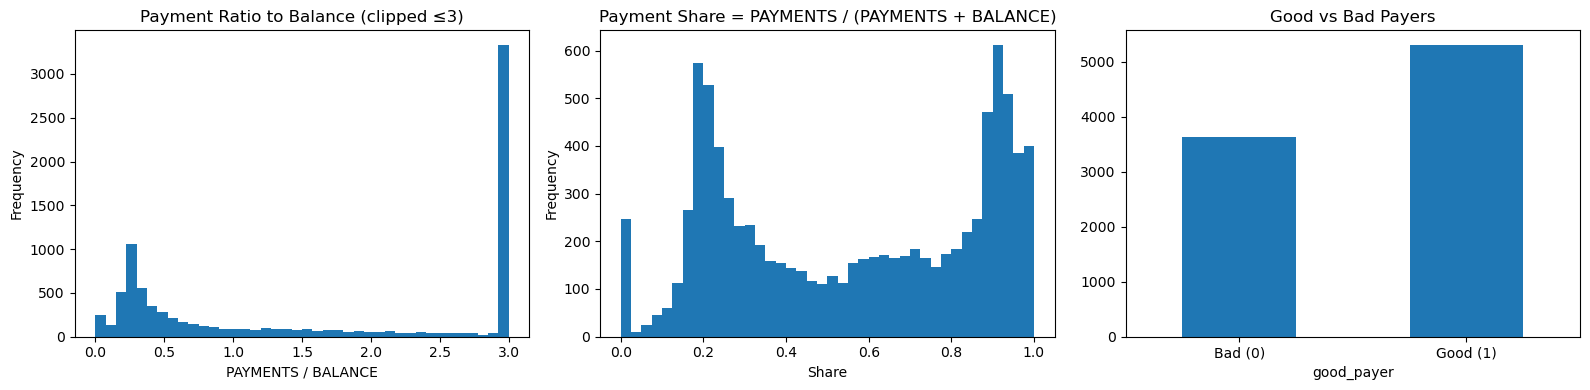

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Payment ratio distribution (clipped for readability)
df["payment_ratio_to_balance"].clip(upper=3).plot(kind="hist", bins=40, ax=axes[0])
axes[0].set_title("Payment Ratio to Balance (clipped ≤3)")
axes[0].set_xlabel("PAYMENTS / BALANCE")

# Payment share distribution (bounded [0,1])
df["payment_share"].plot(kind="hist", bins=40, ax=axes[1])
axes[1].set_title("Payment Share = PAYMENTS / (PAYMENTS + BALANCE)")
axes[1].set_xlabel("Share")

# Good/Bad count
df["good_payer"].value_counts(dropna=False).sort_index().plot(kind="bar", ax=axes[2])
axes[2].set_title("Good vs Bad Payers")
axes[2].set_xticklabels(["Bad (0)","Good (1)"], rotation=0)

plt.tight_layout()
plt.show()


In [7]:
# Drop obvious leakage targets/ratios from features
drop_cols = [id_col, "payment_ratio_to_balance", "payment_share", "good_payer", "BALANCE_safe"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["good_payer"].astype(int)

# Keep only numeric features for this dataset
feat_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
X = X[feat_cols]

# Quick NA check
print("Remaining missing values:\n", X.isna().sum().sort_values(ascending=False).head(10))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


Remaining missing values:
 MINIMUM_PAYMENTS                    313
CREDIT_LIMIT                          1
BALANCE                               0
CASH_ADVANCE_FREQUENCY                0
PRC_FULL_PAYMENT                      0
PAYMENTS                              0
PURCHASES_TRX                         0
CASH_ADVANCE_TRX                      0
PURCHASES_INSTALLMENTS_FREQUENCY      0
BALANCE_FREQUENCY                     0
dtype: int64


((7160, 17), (1790, 17))

In [9]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, feat_cols)],
    remainder="drop"
)

log_reg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)

pipe_log = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", log_reg)
])

pipe_log.fit(X_train, y_train)

pred = pipe_log.predict(X_test)
proba = pipe_log.predict_proba(X_test)[:, 1]

print("Baseline — Logistic Regression")
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("Precision:", round(precision_score(y_test, pred), 4))
print("Recall:", round(recall_score(y_test, pred), 4))
print("F1:", round(f1_score(y_test, pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))


Baseline — Logistic Regression
Accuracy: 0.9726
Precision: 0.9847
Recall: 0.9689
F1: 0.9767
ROC-AUC: 0.9923


In [11]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", rf)
])

pipe_rf.fit(X_train, y_train)

pred_rf = pipe_rf.predict(X_test)
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("Random Forest (Holdout)")
print("Accuracy:", round(accuracy_score(y_test, pred_rf), 4))
print("Precision:", round(precision_score(y_test, pred_rf), 4))
print("Recall:", round(recall_score(y_test, pred_rf), 4))
print("F1:", round(f1_score(y_test, pred_rf), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, proba_rf), 4))

# Stratified CV on training set for stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_auc = cross_val_score(pipe_rf, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)

print("\nCV ROC-AUC (5-fold):", np.round(cv_auc, 4))
print("CV ROC-AUC Mean:", round(cv_auc.mean(), 4), "±", round(cv_auc.std(), 4))

Random Forest (Holdout)
Accuracy: 0.976
Precision: 0.9811
Recall: 0.9783
F1: 0.9797
ROC-AUC: 0.998

CV ROC-AUC (5-fold): [0.9969 0.9978 0.9978 0.9977 0.997 ]
CV ROC-AUC Mean: 0.9974 ± 0.0004


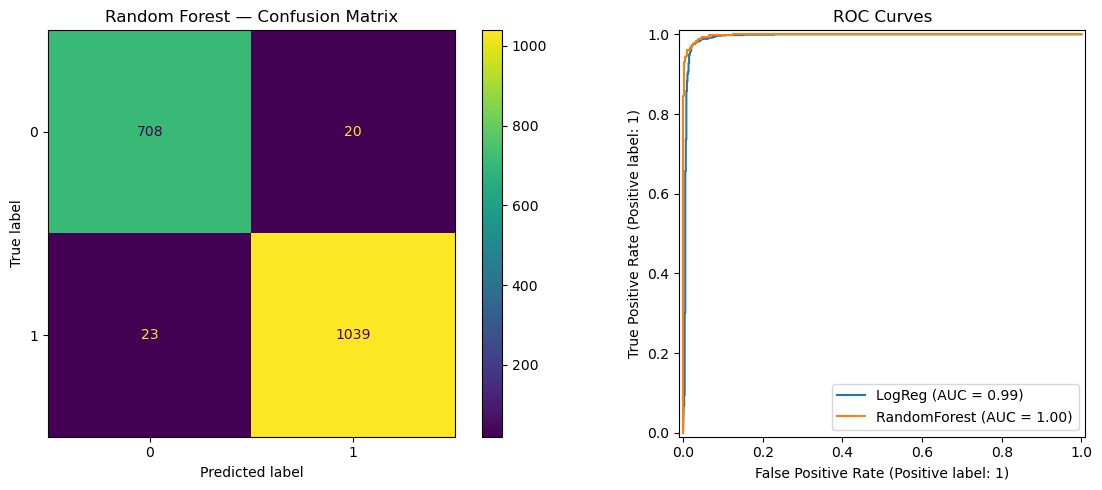

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, pred_rf, ax=ax[0])
ax[0].set_title("Random Forest — Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, proba, name="LogReg", ax=ax[1])
RocCurveDisplay.from_predictions(y_test, proba_rf, name="RandomForest", ax=ax[1])
ax[1].set_title("ROC Curves")

plt.tight_layout()
plt.show()


In [13]:
# Fit on the full training set for importance, evaluate on test
pipe_rf.fit(X_train, y_train)

# Extract the transformed feature names (after ColumnTransformer)
prep = pipe_rf.named_steps["prep"]
num_feat_names = feat_cols  # numeric-only pipeline; names preserved

r = permutation_importance(
    pipe_rf, X_test, y_test,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": num_feat_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

imp_df.head(15)


,feature,importance_mean,importance_std
13,PAYMENTS,0.227709,0.010168
0,BALANCE,0.216034,0.006390
15,PRC_FULL_PAYMENT,0.098324,0.007284
14,MINIMUM_PAYMENTS,0.075587,0.004292
12,CREDIT_LIMIT,0.002235,0.001117
4,INSTALLMENTS_PURCHASES,0.001564,0.000698
2,PURCHASES,0.001564,0.001167
16,TENURE,0.001397,0.000375
1,BALANCE_FREQUENCY,0.001397,0.000625
6,PURCHASES_FREQUENCY,0.001117,0.000559


In [14]:
# Quick aggregates by label
agg_cols = ["BALANCE", "CREDIT_LIMIT", "PURCHASES", "CASH_ADVANCE", "PAYMENTS", "MINIMUM_PAYMENTS"]
summary = df.groupby("good_payer")[agg_cols].median().rename(index={0:"Bad",1:"Good"})
summary = summary.assign(customers=df.groupby("good_payer")["CUST_ID"].count())
summary


,BALANCE,CREDIT_LIMIT,PURCHASES,CASH_ADVANCE,PAYMENTS,MINIMUM_PAYMENTS,customers
good_payer,,,,,,,
Bad,1832.521787,3000.0,159.07,416.566286,584.413797,717.310059,NaN
Good,256.182628,3000.0,515.98,0.000000,1258.023851,184.710533,NaN


In [15]:
import joblib

# Choose RF as best by default (change if Logistic performs better on your data)
best_pipe = pipe_rf

artifacts_dir = Path("./artifacts")
artifacts_dir.mkdir(exist_ok=True)

joblib.dump(best_pipe, artifacts_dir / "good_payer_model.joblib")
with open(artifacts_dir / "feature_list.json", "w", encoding="utf-8") as f:
    json.dump(feat_cols, f, ensure_ascii=False, indent=2)

print("Saved:", (artifacts_dir / "good_payer_model.joblib").resolve())


Saved: C:\Users\ERDAL\AppData\Local\Programs\Microsoft VS Code\artifacts\good_payer_model.joblib


In [16]:
# Example: predict for a single new customer dictionary
def predict_good_payer(sample: Dict[str, float]) -> Dict[str, float]:
    """
    Predicts good_payer probability for one customer using saved model.
    Expects a dict with the same feature names used in training (feat_cols).
    """
    import joblib
    model_path = Path("./artifacts/good_payer_model.joblib")
    feats_path = Path("./artifacts/feature_list.json")
    if not (model_path.exists() and feats_path.exists()):
        raise FileNotFoundError("Model or feature list not found. Run the training cells first.")
    
    model = joblib.load(model_path)
    with open(feats_path, "r", encoding="utf-8") as f:
        feats = json.load(f)
    
    # Build one-row DataFrame in correct column order
    row = {k: sample.get(k, np.nan) for k in feats}
    X_new = pd.DataFrame([row], columns=feats)
    proba = model.predict_proba(X_new)[:, 1][0]
    pred = int(proba >= 0.5)
    return {"proba_good": float(proba), "pred_label": pred}

# Example usage (fill with realistic values for your context)
example = {
    "BALANCE": 1500,
    "BALANCE_FREQUENCY": 0.9,
    "PURCHASES": 1200,
    "ONEOFF_PURCHASES": 500,
    "INSTALLMENTS_PURCHASES": 700,
    "CASH_ADVANCE": 0,
    "PURCHASES_FREQUENCY": 0.6,
    "ONEOFF_PURCHASES_FREQUENCY": 0.3,
    "PURCHASES_INSTALLMENTS_FREQUENCY": 0.4,
    "CASH_ADVANCE_FREQUENCY": 0.0,
    "CASH_ADVANCE_TRX": 0,
    "PURCHASES_TRX": 15,
    "CREDIT_LIMIT": 4000,
    "PAYMENTS": 1100,
    "MINIMUM_PAYMENTS": 100,
    "PRC_FULL_PAYMENT": 0.1,
    "TENURE": 12
}
predict_good_payer(example)


{'proba_good': 0.8763333333333333, 'pred_label': 1}

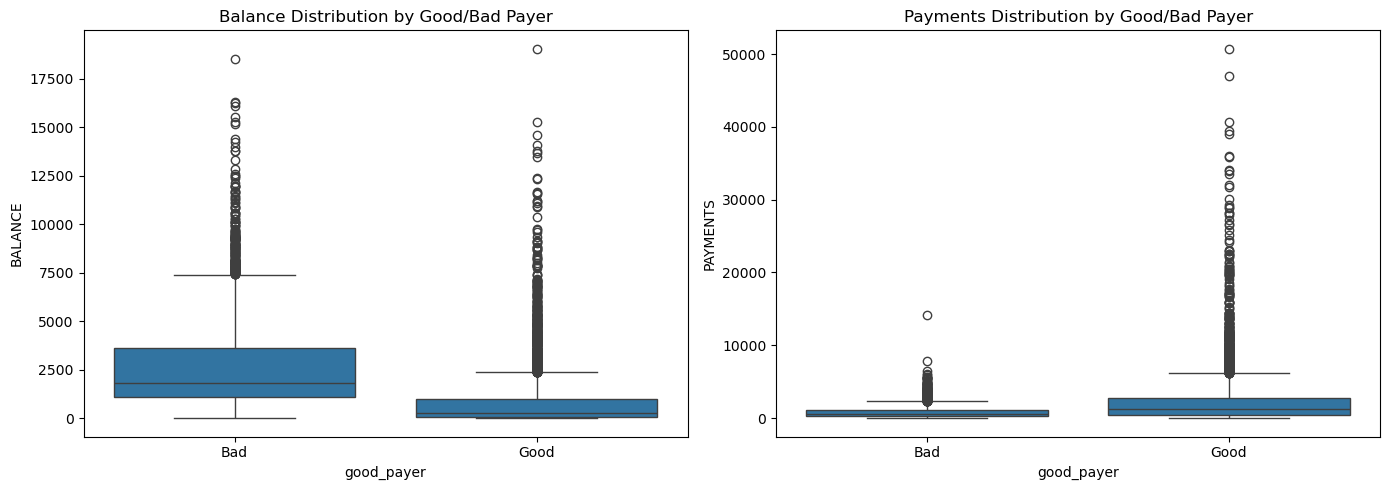

In [18]:
# Compare BALANCE & PAYMENTS by good/bad payer
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.boxplot(x="good_payer", y="BALANCE", data=df, ax=axes[0])
axes[0].set_title("Balance Distribution by Good/Bad Payer")
axes[0].set_xticklabels(["Bad","Good"])

sns.boxplot(x="good_payer", y="PAYMENTS", data=df, ax=axes[1])
axes[1].set_title("Payments Distribution by Good/Bad Payer")
axes[1].set_xticklabels(["Bad","Good"])

plt.tight_layout()
plt.show()

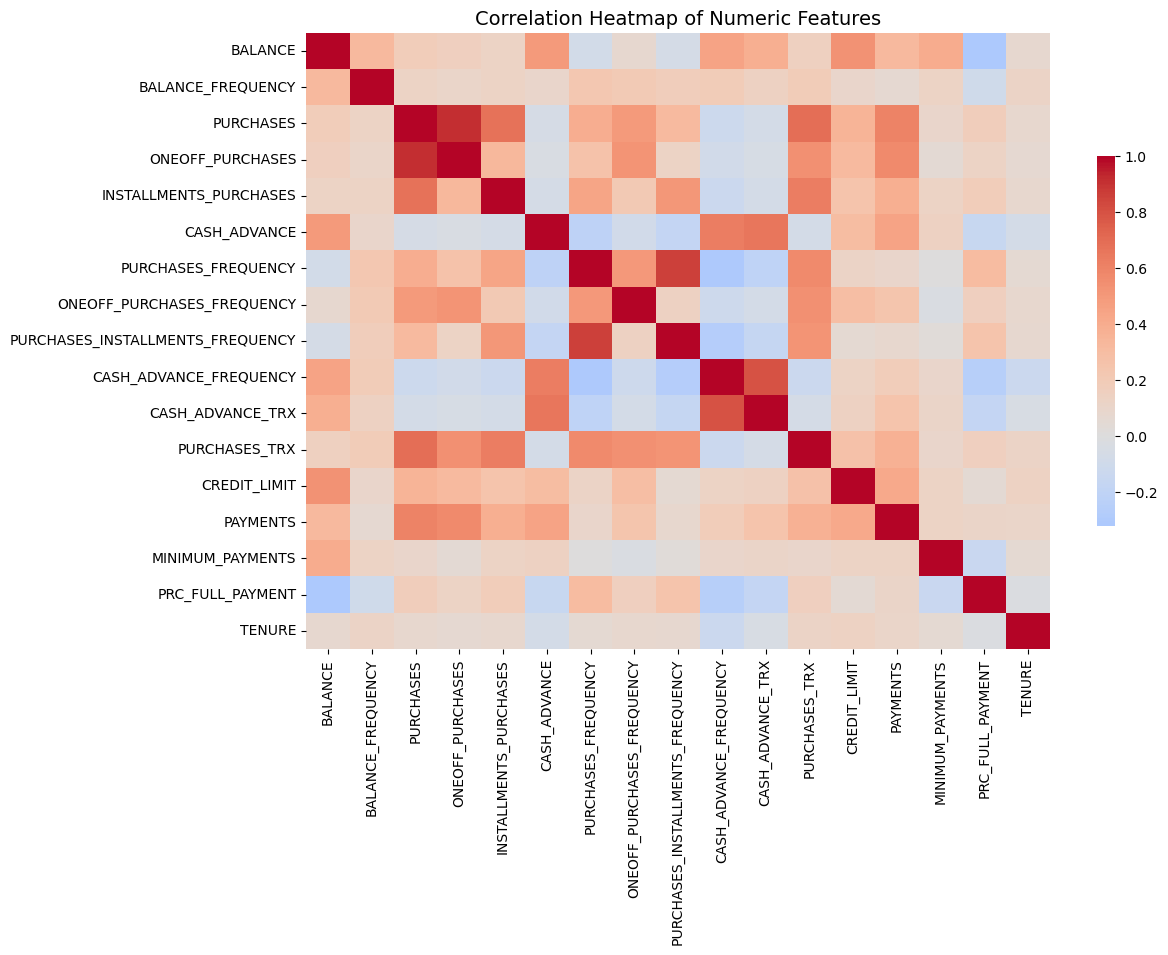

In [19]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink':0.6})
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()


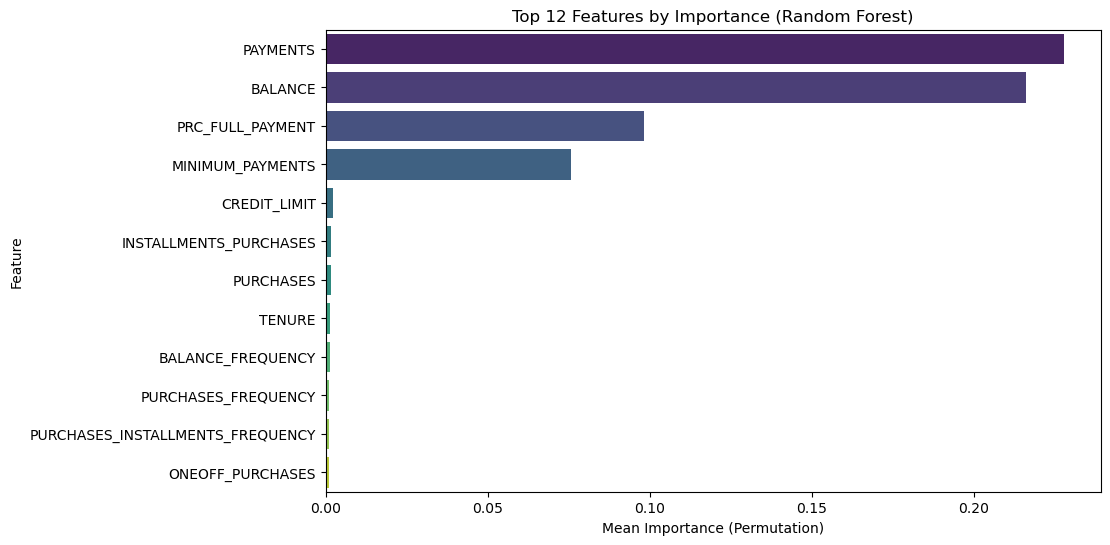

In [20]:
topn = 12
plt.figure(figsize=(10,6))
sns.barplot(x="importance_mean", y="feature", data=imp_df.head(topn), palette="viridis")
plt.title(f"Top {topn} Features by Importance (Random Forest)")
plt.xlabel("Mean Importance (Permutation)")
plt.ylabel("Feature")
plt.show()
